# FC-DNN for drug-cytokine interactions

The best DNN topology is used to print the model performance.

Starting with the imports:

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, StratifiedKFold
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras import regularizers

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import confusion_matrix,accuracy_score, roc_auc_score, f1_score, \
     recall_score, precision_score,classification_report, roc_curve, auc, matthews_corrcoef

import time as tm
from keras.models import load_model

from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint

from ds_utils import *

Define a function to create a FC-DNN model, required for KerasClassifier. The network has the following layers:
- topology       = n-n*2-n*3-n*2-n
- input layer    = 120 neurons (features)
- hidden layer 1 = 120 neurons
- hidden layer 2 = 240 neurons
- hidden layer 3 = 360 neurons
- hidden layer 4 = 240 neurons
- hidden layer 5 = 120 neurons
- output layer   = 1 neuron (class 0 / 1)
- activations    = relu
- algorithm      = Adam

Note = added Batch Normalization and Dropout 0.5 for each hidden layer.

In [39]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(120, input_dim=120, activation='relu', kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))
    model.add(Dense(240, activation='relu', kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))
    model.add(Dense(360, activation='relu', kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))
    model.add(Dense(240, activation='relu', kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))
    model.add(Dense(120, activation='relu', kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))
    model.add(Dense(1, kernel_initializer='glorot_normal', activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Set the parameters such as input files with training, test subsets, number of features, resulting file with statistics, seed value for reproductibility:

In [40]:
# Dataset params
listFiles_tr = 'fs-rf.s.ds_MA_tr.csv'
listFiles_ts = 'fs-rf.s.ds_MA_ts.csv'
no_cols     = 121 # no of columns in the dataset (features + class)
no_features = 120 # no of features

# dataset folder
WorkingFolder  = './datasets/'

# output variable
outVar = 'Lij'

# Results file
resFileCSV = 'DL_best_model.csv'

# fix random seed for reproducibility
seed = 0
numpy.random.seed(seed)

Load dataset and calculate the class weights:

In [41]:
# loading datasets

# load training set
print ("\n--> Reading dataset ...")

values = datasets_parser(listFiles_tr, listFiles_ts,outVar=outVar, WorkingFolder=WorkingFolder)
X_train = values[0] # X_train data
y_train = values[1] # y_train data
X_test  = values[2] # X_test data
y_test  = values[3] # y_test data

print('X_tr_data=', X_train.shape)
print('y_tr_data=', y_train.shape)
print('X_ts_data=', X_test.shape)
print('y_ts_data=', y_test.shape)

# calculate the class weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 numpy.unique(y_train),
                                                 y_train)
print('Done!')


--> Reading dataset ...
X_tr_data= (9679, 120)
y_tr_data= (9679,)
X_ts_data= (3227, 120)
y_ts_data= (3227,)
Done!


Initialize the FC-DNN model, train it and print the model summary:

In [64]:
start_time = tm.time() # get starting time
model = create_model()
print ("-> Training the model ...")
history = model.fit(X_train, y_train, validation_data=(X_test,y_test),
                    batch_size=1024,
                    epochs=120,
                    verbose=0,shuffle=False, class_weight=class_weights)
print(model.summary())
time_s = (tm.time() - start_time)
print("\Training time: %0.1f s" % (time_s))
print("Done!\n")

-> Training the model ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 120)               14520     
_________________________________________________________________
batch_normalization_36 (Batc (None, 120)               480       
_________________________________________________________________
dropout_36 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 240)               29040     
_________________________________________________________________
batch_normalization_37 (Batc (None, 240)               960       
_________________________________________________________________
dropout_37 (Dropout)         (None, 240)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 360)          

Calculate ACC, AUC and F1-score for training and test:

In [65]:
score_train = model.evaluate(X_train, y_train, verbose=1)
y_pred_train = model.predict(X_train)
roc_train = roc_auc_score(y_train, y_pred_train)

score_test = model.evaluate(X_test, y_test, verbose=0)
y_pred_test = model.predict(X_test)

roc_test = roc_auc_score(y_test, y_pred_test)

f1_test = f1_score(y_test, y_pred_test.round(),pos_label=1,
                   average='binary',sample_weight=None, labels=y_test)

9679/9679 [==============================] - 1s 81us/step


Append statistics to an output CSV file:

In [66]:
csvData = "ROC tr,"+str(roc_train)+',SCORE,'+str(score_train[1])+',ROC ts,'+ \
          str(roc_test)+',SCORE ts,'+str(score_test[1])+',F1-score'+','+str(f1_test)
print(csvData)

print("Total test AUROC score = {0:0.4f}".format(roc_test))

fout = open(resFileCSV, 'a')
fout.write(csvData+'\n')
fout.close()

ROC tr,0.9079026568272613,SCORE,0.8386196921292706,ROC ts,0.9042520580885238,SCORE ts,0.832352029601228,F1-score,0.7092960773777538
Total test AUROC score = 0.9043


Save the model:

In [67]:
model.save('DL_best_model_0.6.h5')  # creates a HDF5 file 'my_model.h5'

Create plots of lost and ACC during traing:

dict_keys(['val_loss', 'loss', 'val_acc', 'acc'])


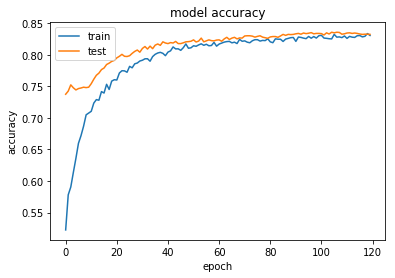

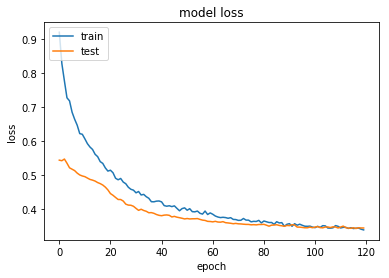

In [71]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.ylim(0.80,0.85)
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [69]:
recall_score(y_test, y_pred_test.round(), average=None)

array([0.85054576, 0.78106509])

In [70]:
precision_score(y_test, y_pred_test.round(), average=None)

array([0.91632745, 0.6496063 ])

### G1 predictions with the best model

In [82]:
# reading G1 selected features standardized
print('-> Reading:','fs-rf.s.ds_MA_G1.csv','...')
df_G1_sel = pd.read_csv(os.path.join(WorkingFolder, 'fs-rf.s.ds_MA_G1.csv'))
print('Columns:',len(df_G1_sel.columns),'Rows:',len(df_G1_sel))
print('Done')
print(list(df_G1_sel.columns))

-> Reading: fs-rf.s.ds_MA_G1.csv ...
Columns: 121 Rows: 1384
Done
['MA-C1SP1-STANDARD_TYPE_UNITSj', 'MA-khs.sBr-STANDARD_TYPE_UNITSj', 'MA-khs.tN-STANDARD_TYPE_UNITSj', 'MA-khs.dsN-STANDARD_TYPE_UNITSj', 'MA-C4SP3-STANDARD_TYPE_UNITSj', 'MA-khs.ddssS-STANDARD_TYPE_UNITSj', 'MA-khs.aaS-STANDARD_TYPE_UNITSj', 'MA-khs.ssssC-STANDARD_TYPE_UNITSj', 'MA-MDEC.44-STANDARD_TYPE_UNITSj', 'MA-khs.tsC-STANDARD_TYPE_UNITSj', 'MA-khs.dsN-ASSAY_CHEMBLID', 'MA-khs.aaS-ASSAY_CHEMBLID', 'MA-C3SP3-ASSAY_CHEMBLID', 'MA-MDEN.11-ASSAY_CHEMBLID', 'MA-khs.dsCH-ASSAY_CHEMBLID', 'MA-MDEO.12-ASSAY_CHEMBLID', 'MA-WPATH-ASSAY_CHEMBLID', 'MA-khs.aasN-ASSAY_CHEMBLID', 'MA-LipinskiFailures-ASSAY_CHEMBLID', 'MA-PetitjeanNumber-ASSAY_CHEMBLID', 'MA-MDEC.23-ASSAY_TYPE', 'MA-MDEC.33-ASSAY_TYPE', 'MA-MDEN.11-ASSAY_TYPE', 'MA-khs.tsC-ASSAY_TYPE', 'MA-SP.1-ASSAY_TYPE', 'MA-SP.2-ASSAY_TYPE', 'MA-SP.4-ASSAY_TYPE', 'MA-SP.5-ASSAY_TYPE', 'MA-VP.1-ASSAY_TYPE', 'MA-VP.5-ASSAY_TYPE', 'MA-naAromAtom-ASSAY_ORGANISM', 'MA-ATSm1-ASSAY

In [83]:
Sel_Feats = df_G1_sel.columns.drop('Lij')
df_G1_feats = df_G1_sel[Sel_Feats]
print('Sel Columns:',len(df_G1_feats.columns),'Sel Rows:',len(df_G1_feats))
df_G1_feats.head()

Sel Columns: 120 Sel Rows: 1384


,MA-C1SP1-STANDARD_TYPE_UNITSj,MA-khs.sBr-STANDARD_TYPE_UNITSj,MA-khs.tN-STANDARD_TYPE_UNITSj,MA-khs.dsN-STANDARD_TYPE_UNITSj,MA-C4SP3-STANDARD_TYPE_UNITSj,MA-khs.ddssS-STANDARD_TYPE_UNITSj,MA-khs.aaS-STANDARD_TYPE_UNITSj,MA-khs.ssssC-STANDARD_TYPE_UNITSj,MA-MDEC.44-STANDARD_TYPE_UNITSj,MA-khs.tsC-STANDARD_TYPE_UNITSj,...,MA-comp_S-TARGET_CHEMBLID,MA-CHOC760101.lag27-TARGET_CHEMBLID,MA-CHAM810101.lag10-TARGET_CHEMBLID,MA-CHAM810101.lag21-TARGET_CHEMBLID,MA-CHAM810101.lag20-TARGET_CHEMBLID,MA-CHAM810101.lag19-TARGET_CHEMBLID,MA-CHAM810101.lag18-TARGET_CHEMBLID,MA-CHAM810101.lag17-TARGET_CHEMBLID,MA-CHAM810101.lag16-TARGET_CHEMBLID,MA-CHAM810101.lag15-TARGET_CHEMBLID
0,-0.232991,7.732223,-0.217442,-0.327726,-0.171562,-0.548478,-0.413133,-0.478792,-0.006035,-0.429242,...,1.342387,-2.695403,-1.385156,-1.578877,1.907829,-0.845025,-0.337901,1.838355,-0.993784,0.702287
1,-0.232991,7.732223,-0.217442,-0.327726,-0.171562,-0.548478,-0.413133,-0.478792,-0.006035,-0.429242,...,1.342387,-2.695403,-1.385156,-1.578877,1.907829,-0.845025,-0.337901,1.838355,-0.993784,0.702287
2,-0.232991,7.732223,-0.217442,-0.327726,-0.171562,-0.548478,-0.413133,-0.478792,-0.006035,-0.429242,...,1.342387,-2.695403,-1.385156,-1.578877,1.907829,-0.845025,-0.337901,1.838355,-0.993784,0.702287
3,-0.141418,7.808540,-0.134548,-0.101971,-0.365039,-0.181906,-0.277549,-0.448202,-0.022812,-0.115554,...,1.342387,-2.695403,-1.385156,-1.578877,1.907829,-0.845025,-0.337901,1.838355,-0.993784,0.702287
4,-0.141418,7.808540,-0.134548,-0.101971,-0.365039,-0.181906,-0.277549,-0.448202,-0.022812,-0.115554,...,1.342387,-2.695403,-1.385156,-1.578877,1.907829,-0.845025,-0.337901,1.838355,-0.993784,0.702287


Make G1 predictions:

In [84]:
y_pred_G1 = model.predict(df_G1_feats.values)
y_pred_class_G1 = model.predict_classes(df_G1_feats.values)

In [85]:
df_G1_sel['Prob_yPred']=y_pred_G1
df_G1_sel['yPredClass']=y_pred_class_G1

In [86]:
df_G1_sel.to_csv(os.path.join(WorkingFolder, 'G1_predictions.csv'), index=False)

In [87]:
# append to details
df_G1_detx = pd.read_csv(os.path.join(WorkingFolder, 'ds.G1_details.csv'))
df_G1_detx['Prob_yPred']=y_pred_G1
df_G1_detx['yPredClass']=y_pred_class_G1
# save new details
df_G1_detx.to_csv(os.path.join(WorkingFolder, 'G1_pred_details.csv'), index=False)

All the G1 predictions with all other details could be found in "G1_pred_details.csv"!

Write only G1 - experimental conditions - prediction:

In [88]:
colsx = ['CMPD_CHEMBLID','CANONICAL_SMILES','PROTEIN_ACCESSION',
         'STANDARD_TYPE_UNITSj','ASSAY_CHEMBLID','ASSAY_TYPE',
         'ASSAY_ORGANISM','ORGANISM','TARGET_CHEMBLID','yPredClass']
# save only experimental conditions + predictions
df_G1_detx[colsx].to_csv(os.path.join(WorkingFolder, 'G1_predictionsExperConds.csv'), index=False)
print('Done!')

Done!
